In [48]:
# All imports are taken from Blackboard "Week __ Interactive Student" notebooks
# Aimed to remain consistent with methods provided by professor for examples
import io
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import math
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency

np.random.seed(42)
plt.rcParams['figure.figsize'] = (8,4)
sns.set_style("whitegrid")

In [50]:
# File path
df = pd.read_csv("housing.csv")
df.columns = [c.strip() for c in df.columns]

display(df.head())
print("Dataset Shape:", df.shape)
print("------------------------------------")
print("Null values in each column:")
df.isnull().sum()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


Dataset Shape: (545, 13)
------------------------------------
Null values in each column:


price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

## Basic Data Cleaning
- standardizing boolean columns so tests can run correctly
- ensuring consistent formatting across all columns

In [53]:
binary_cols = ["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea"]

for col in binary_cols:
    if col in df.columns:
        # Change to lowercase string
        df[col] = df[col].astype(str).str.lower()
        # Map values to 1 and 0
        df[col] = df[col].replace({
            'yes': 1, 'y': 1, 'true': 1, 't': 1, '1': 1,
            'no': 0, 'n': 0, 'false': 0, 'f': 0, '0': 0
        })
        # Convert numeric strings to real numbers
        df[col] = pd.to_numeric(df[col], errors='ignore')

if 'furnishingstatus' in df.columns:
    df['furnishingstatus'] = df['furnishingstatus'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   price             545 non-null    int64   
 1   area              545 non-null    int64   
 2   bedrooms          545 non-null    int64   
 3   bathrooms         545 non-null    int64   
 4   stories           545 non-null    int64   
 5   mainroad          545 non-null    int64   
 6   guestroom         545 non-null    int64   
 7   basement          545 non-null    int64   
 8   hotwaterheating   545 non-null    int64   
 9   airconditioning   545 non-null    int64   
 10  parking           545 non-null    int64   
 11  prefarea          545 non-null    int64   
 12  furnishingstatus  545 non-null    category
dtypes: category(1), int64(12)
memory usage: 51.9 KB


/var/folders/15/5cyv08td2k93np_jby77mwqm0000gn/T/ipykernel_7106/1607851875.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({
/var/folders/15/5cyv08td2k93np_jby77mwqm0000gn/T/ipykernel_7106/1607851875.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')
/var/folders/15/5cyv08td2k93np_jby77mwqm0000gn/T/ipykernel_7106/1607851875.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option(

## Sampling Distribution and Statistical Inference
- identifying 'price' as our target variable and displaying it's count, mean, and standard deviation
- utilizing Central Limit Theorem to make sure sampling distribution of the mean is normal
- displaying a range of where the true mean may be with a 95% confidence interval

Observed n=545, mean=4766729.248, std=1868722.828
Mean of sampling distribution = 4764507.6038
95% CI = (4752911.1704, 4776104.0372)


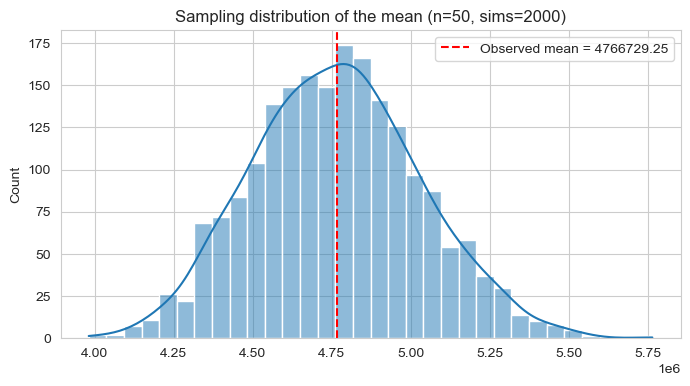

In [56]:
target = 'price'
if target not in df.columns:
    raise ValueError(f"{target} not in dataset")

pop = df[target].dropna()
n_pop = len(pop)
pop_mean = pop.mean()
pop_std = pop.std(ddof=0)
print(f"Observed n={n_pop}, mean={pop_mean:.3f}, std={pop_std:.3f}")

# Central Limit Theorem: build sampling distribution of the sample mean
sample_size = min(50, n_pop)
n_sims = 2000
means = []
for _ in range(n_sims):
    s = df[target].dropna().sample(sample_size, replace=True)
    means.append(s.mean())
means = np.array(means)

# Standard 95% CI (t-distribution)
mean_sample = means.mean()
se_sample = means.std(ddof=1) / np.sqrt(len(means))

ci_lower, ci_upper = stats.t.interval(
    0.95, df=len(means)-1, loc=mean_sample, scale=se_sample
)

print(f"Mean of sampling distribution = {mean_sample:.4f}")
print(f"95% CI = ({ci_lower:.4f}, {ci_upper:.4f})")

# Plot sampling distribution
plt.figure()
sns.histplot(means, kde=True)
plt.axvline(pop_mean, color='red', linestyle='--', label=f'Observed mean = {pop_mean:.2f}')
plt.title(f"Sampling distribution of the mean (n={sample_size}, sims={n_sims})")
plt.legend()
plt.show()

## Correlation Analysis
- testing for linear association using t-statistic (df = n-2)
- heatmap displays strong correlations among variables


Correlation between price and area:
  Correlation: 0.536
  p-value: 0.0000
  Description: positive relationship (higher price tends to relate to higher area)

Correlation between price and bedrooms:
  Correlation: 0.366
  p-value: 0.0000
  Description: positive relationship (higher price tends to relate to higher bedrooms)

Correlation between area and bedrooms:
  Correlation: 0.152
  p-value: 0.0004
  Description: positive relationship (higher area tends to relate to higher bedrooms)


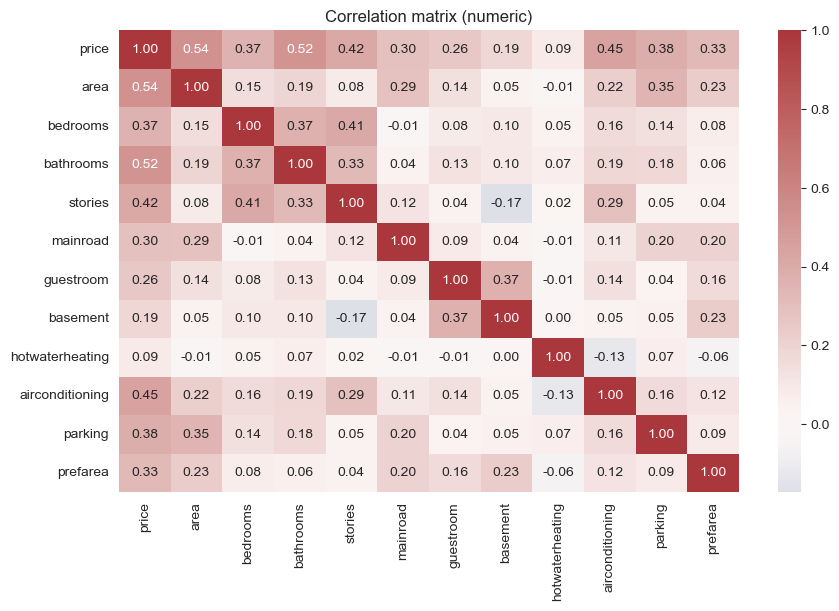

In [59]:
# Correlation analysis for a few pairs (prints test stat, df, p-value)
pairs = [('price','area'), ('price','bedrooms'), ('area','bedrooms')]
for x, y in pairs:
    if x in df.columns and y in df.columns:
        clean = df[[x, y]].dropna()
        r, p_value = stats.pearsonr(clean[x], clean[y])
        print(f"\nCorrelation between {x} and {y}:")
        print(f"  Correlation: {r:.3f}")
        print(f"  p-value: {p_value:.4f}")
        if r > 0:
            desc = f"positive relationship (higher {x} tends to relate to higher {y})"
        elif r < 0:
            desc = f"negative relationship (higher {x} tends to relate to lower {y})"
        else:
            desc = "no linear relationship"
        print(f"  Description: {desc}")

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    plt.figure(figsize=(10,6))
    corr = df[num_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
    plt.title("Correlation matrix (numeric)")
    plt.show()

## ANOVA Testing
- testing is all group means are equal
- F-statistic = between group variance / within group variance
- if p < 0.05, at least one pair is different
- Tukey's method for pairwise comparisons only

Groups: ['furnished', 'semi-furnished', 'unfurnished']


,sum_sq,df,F,PR(>F)
C(furnishingstatus),1.797950e+14,2.0,28.2721,0.0
Residual,1.723413e+15,542.0,NaN,NaN


F = 28.2721, df_between = 2, df_within = 542, p = 2.09287e-12 (Distribution: F-distribution)
Significant ANOVA: run Tukey HSD for pairwise group differences.
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
    group1         group2        meandiff   p-adj      lower         upper     reject
-------------------------------------------------------------------------------------
     furnished semi-furnished  -588171.7709 0.0064 -1038521.5649  -137821.9769   True
     furnished    unfurnished -1481864.5393    0.0 -1955270.1751 -1008458.9036   True
semi-furnished    unfurnished  -893692.7684    0.0 -1313257.0074  -474128.5294   True
-------------------------------------------------------------------------------------


/var/folders/15/5cyv08td2k93np_jby77mwqm0000gn/T/ipykernel_7106/1073739859.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  F = anova_res['F'][0]
/var/folders/15/5cyv08td2k93np_jby77mwqm0000gn/T/ipykernel_7106/1073739859.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval = anova_res['PR(>F)'][0]
/var/folders/15/5cyv08td2k93np_jby77mwqm0000gn/T/ipykernel_7106/1073739859.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

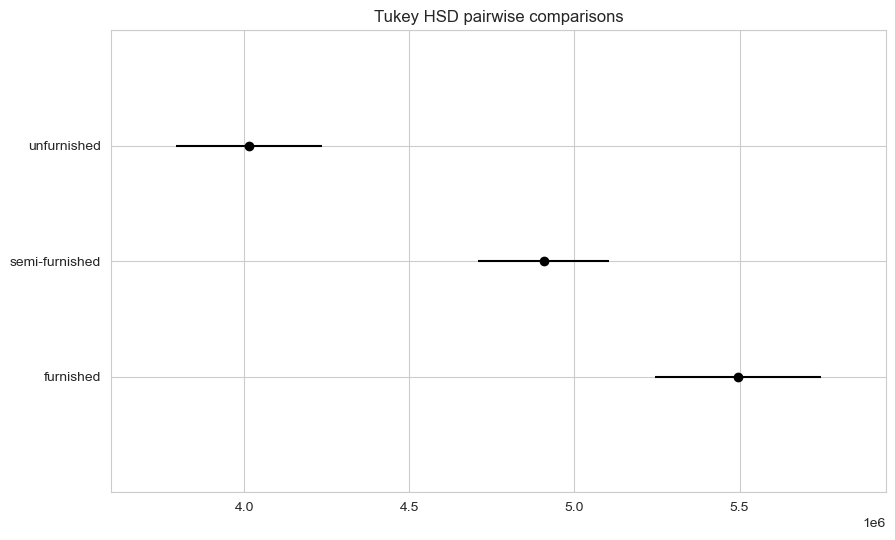

In [62]:
cat = 'furnishingstatus'
if cat in df.columns:
    df_a = df[[target, cat]].dropna()
    df_a[cat] = df_a[cat].astype('category')
    print("Groups:", df_a[cat].cat.categories.tolist())
    model = ols(f"{target} ~ C({cat})", data=df_a).fit()
    anova_res = anova_lm(model, typ=2)   # Type II
    display(anova_res.round(4))
    # Extract F, df, p
    if 'F' in anova_res.columns:
        F = anova_res['F'][0]
        pval = anova_res['PR(>F)'][0]
        df_between = int(anova_res['df'][0])
        df_within = int(anova_res['df'][1])
        print(f"F = {F:.4f}, df_between = {df_between}, df_within = {df_within}, p = {pval:.6g} (Distribution: F-distribution)")
        if pval < 0.05:
            print("Significant ANOVA: run Tukey HSD for pairwise group differences.")
            tuk = pairwise_tukeyhsd(endog=df_a[target], groups=df_a[cat], alpha=0.05)
            print(tuk)
            tuk.plot_simultaneous()
            plt.title("Tukey HSD pairwise comparisons")
            plt.show()
        else:
            print("No evidence of group mean differences (fail to reject H0).")
else:
    print("ANOVA skipped: furnishingstatus not in dataset")

Groups: [0, 1]


,sum_sq,df,F,PR(>F)
C(prefarea),2.069794e+14,1.0,66.2586,0.0
Residual,1.696229e+15,543.0,NaN,NaN


F = 66.2586, df_between = 1, df_within = 543, p = 2.71837e-15 (Distribution: F-distribution)
Significant ANOVA: run Tukey HSD for pairwise group differences.
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj    lower        upper     reject
-----------------------------------------------------------------
     0      1 1453746.9261   0.0 1102926.6222 1804567.2301   True
-----------------------------------------------------------------


/var/folders/15/5cyv08td2k93np_jby77mwqm0000gn/T/ipykernel_7106/1591233904.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  F = anova_res['F'][0]
/var/folders/15/5cyv08td2k93np_jby77mwqm0000gn/T/ipykernel_7106/1591233904.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval = anova_res['PR(>F)'][0]
/var/folders/15/5cyv08td2k93np_jby77mwqm0000gn/T/ipykernel_7106/1591233904.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

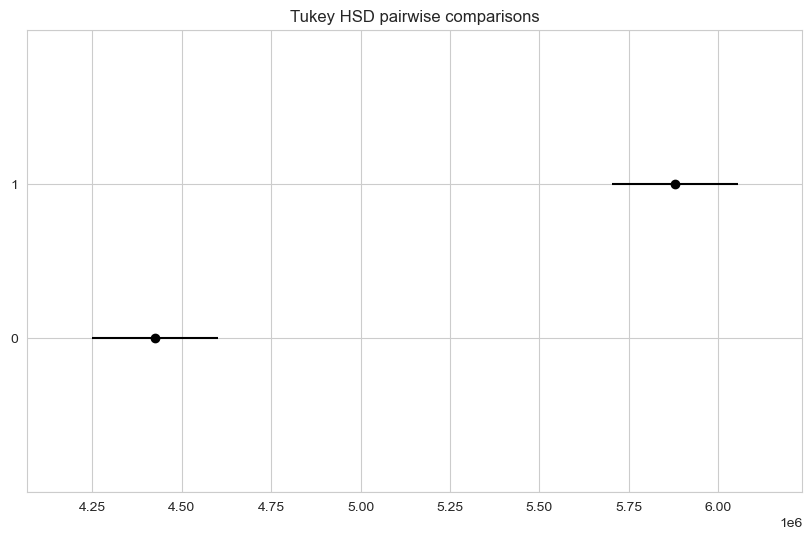

In [64]:
cat = 'prefarea'  

if cat in df.columns:
    df_a = df[[target, cat]].dropna()
    df_a[cat] = df_a[cat].astype('category')
    print("Groups:", df_a[cat].cat.categories.tolist())

    model = ols(f"{target} ~ C({cat})", data=df_a).fit()
    anova_res = anova_lm(model, typ=2)   # Type II
    display(anova_res.round(4))

    # Extract F, df, p
    if 'F' in anova_res.columns:
        F = anova_res['F'][0]
        pval = anova_res['PR(>F)'][0]
        df_between = int(anova_res['df'][0])
        df_within = int(anova_res['df'][1])
        print(f"F = {F:.4f}, df_between = {df_between}, df_within = {df_within}, "
              f"p = {pval:.6g} (Distribution: F-distribution)")
        if pval < 0.05:
            print("Significant ANOVA: run Tukey HSD for pairwise group differences.")
            tuk = pairwise_tukeyhsd(endog=df_a[target], groups=df_a[cat], alpha=0.05)
            print(tuk)
            tuk.plot_simultaneous()
            plt.title("Tukey HSD pairwise comparisons")
            plt.show()
        else:
            print("No evidence of group mean differences (fail to reject H0).")
else:
    print("ANOVA skipped: Not in dataset")

Groups: [0, 1]


,sum_sq,df,F,PR(>F)
C(mainroad),1.677653e+14,1.0,52.4918,0.0
Residual,1.735443e+15,543.0,NaN,NaN


F = 52.4918, df_between = 1, df_within = 543, p = 1.4901e-12 (Distribution: F-distribution)
Significant ANOVA: run Tukey HSD for pairwise group differences.
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj    lower        upper     reject
-----------------------------------------------------------------
     0      1 1592872.7836   0.0 1161003.4294 2024742.1378   True
-----------------------------------------------------------------


/var/folders/15/5cyv08td2k93np_jby77mwqm0000gn/T/ipykernel_7106/2373508830.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  F = anova_res['F'][0]
/var/folders/15/5cyv08td2k93np_jby77mwqm0000gn/T/ipykernel_7106/2373508830.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval = anova_res['PR(>F)'][0]
/var/folders/15/5cyv08td2k93np_jby77mwqm0000gn/T/ipykernel_7106/2373508830.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

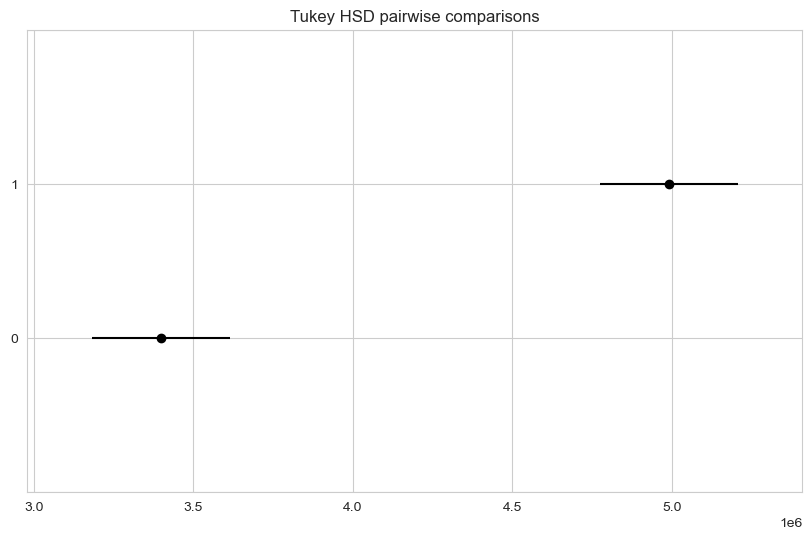

In [68]:
cat = 'mainroad'   

if cat in df.columns:
    df_a = df[[target, cat]].dropna()
    df_a[cat] = df_a[cat].astype('category')
    print("Groups:", df_a[cat].cat.categories.tolist())

    model = ols(f"{target} ~ C({cat})", data=df_a).fit()
    anova_res = anova_lm(model, typ=2)   # Type II
    display(anova_res.round(4))

    # Extract F, df, p
    if 'F' in anova_res.columns:
        F = anova_res['F'][0]
        pval = anova_res['PR(>F)'][0]
        df_between = int(anova_res['df'][0])
        df_within = int(anova_res['df'][1])
        print(
            f"F = {F:.4f}, df_between = {df_between}, "
            f"df_within = {df_within}, p = {pval:.6g} "
            "(Distribution: F-distribution)"
        )

        if pval < 0.05:
            print("Significant ANOVA: run Tukey HSD for pairwise group differences.")
            tuk = pairwise_tukeyhsd(endog=df_a[target],
                                    groups=df_a[cat],
                                    alpha=0.05)
            print(tuk)
            tuk.plot_simultaneous()
            plt.title("Tukey HSD pairwise comparisons")
            plt.show()
        else:
            print("No evidence of group mean differences (fail to reject H0).")
else:
    print("ANOVA skipped: Not in dataset")


## Simple Linear Regression
- focusing on 'price' and 'area'
- includes key statistics
- t-test checks if slope is any value but zero (there is linear association)
- R-squared tells fraction of variance explained
- residual plots check for linearity, homoscedasticity, and normality

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     218.9
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           7.39e-42
Time:                        20:24:36   Log-Likelihood:                -8551.2
No. Observations:                 545   AIC:                         1.711e+04
Df Residuals:                     543   BIC:                         1.712e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.387e+06   1.74e+05     13.681      0.0

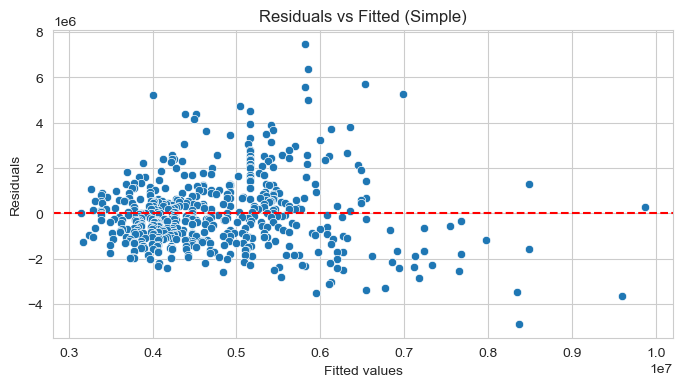

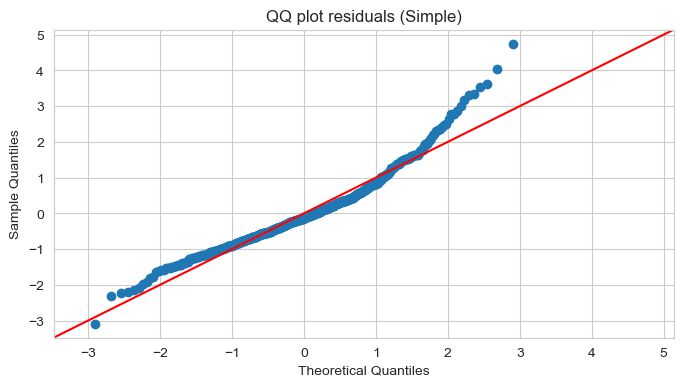

In [14]:
if 'price' in df.columns and 'area' in df.columns:
    df_slr = df[['price','area']].dropna()
    X = sm.add_constant(df_slr['area'])
    y = df_slr['price']
    slr = sm.OLS(y, X).fit()
    print(slr.summary())
    coef = slr.params['area']
    se = slr.bse['area']
    tstat = slr.tvalues['area']
    pval = slr.pvalues['area']
    df_resid = int(slr.df_resid)
    ci_low, ci_high = slr.conf_int().loc['area']
    print(f"Slope = {coef:.4f}, SE = {se:.4f}, t = {tstat:.3f}, df = {df_resid}, p = {pval:.6g}")
    print(f"95% CI for slope: ({ci_low:.3f}, {ci_high:.3f}) (t-distribution with df={df_resid})")

    fitted = slr.fittedvalues
    resid = slr.resid
    plt.figure()
    sns.scatterplot(x=fitted, y=resid)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Fitted (Simple)")
    plt.show()

    sm.qqplot(resid, line='45', fit=True)
    plt.title("QQ plot residuals (Simple)")
    plt.show()
else:
    print("SLR skipped: 'area' or 'price' not present.")

## Multiple Linear Regression
- coefficients are partial effects holding other variables constant
- p-values identify statistically significant predictors
- VIF > 5 is a sign of poor multicollinearity (may require regularization)
- residual plots help to detect non-linearity or non-normal residuals

MLR formula: price ~ area + bedrooms + bathrooms + stories + parking + mainroad + guestroom + basement + hotwaterheating + airconditioning + prefarea + C(furnishingstatus)
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     87.52
Date:                Fri, 05 Dec 2025   Prob (F-statistic):          9.07e-123
Time:                        20:24:37   Log-Likelihood:                -8331.5
No. Observations:                 545   AIC:                         1.669e+04
Df Residuals:                     531   BIC:                         1.675e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,42771.6939,264313.3089,0.1618,0.8715,-476456.3566,5.619997e+05
C(furnishingstatus)[T.semi-furnished],-46344.6200,116574.0890,-0.3976,0.6911,-275347.6060,1.826584e+05
C(furnishingstatus)[T.unfurnished],-411234.3862,126210.5580,-3.2583,0.0012,-659167.6524,-1.633011e+05
area,244.1394,24.2888,10.0515,0.0000,196.4254,2.918533e+02
bedrooms,114787.5602,72598.6650,1.5811,0.1144,-27828.2749,2.574034e+05
bathrooms,987668.1073,103361.9784,9.5554,0.0000,784619.5405,1.190717e+06
stories,450848.0029,64168.9309,7.0260,0.0000,324791.8878,5.769041e+05
parking,277107.1013,58525.8884,4.7348,0.0000,162136.4136,3.920778e+05
mainroad,421272.5887,142224.1288,2.9620,0.0032,141881.5984,7.006636e+05
guestroom,300525.8596,131710.2194,2.2817,0.0229,41788.8300,5.592629e+05



VIF table (including intercept):


,feature,VIF
0,Intercept,33.38
1,C(furnishingstatus)[T.semi-furnished],1.58
2,C(furnishingstatus)[T.unfurnished],1.67
3,area,1.33
4,bedrooms,1.37
5,bathrooms,1.29
6,stories,1.48
7,parking,1.21
8,mainroad,1.17
9,guestroom,1.21


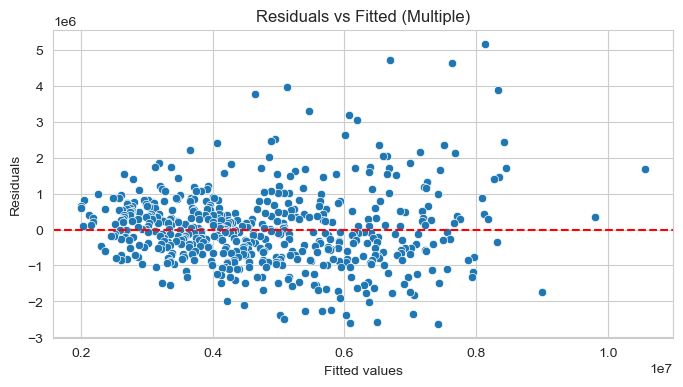

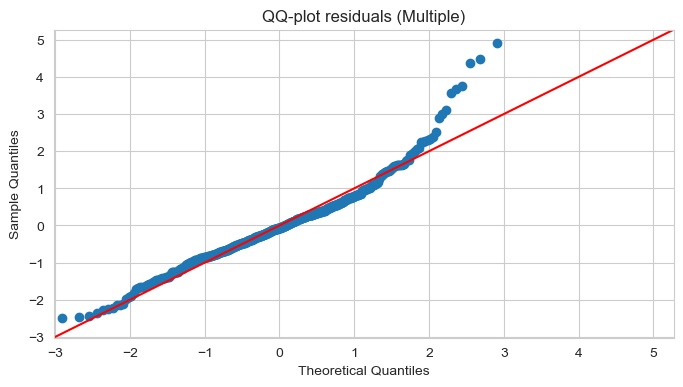

In [16]:
# Candidate predictors: numeric and binary flags + furnishingstatus (if present)
predictors = []
for c in ['area','bedrooms','bathrooms','stories','parking']:
    if c in df.columns:
        predictors.append(c)
for b in binary_cols:
    if b in df.columns:
        predictors.append(b)
if 'furnishingstatus' in df.columns:
    predictors.append('C(furnishingstatus)')  # use categorical via patsy/ols

formula_rhs = " + ".join(predictors) if predictors else "1"
formula = f"price ~ {formula_rhs}"
print("MLR formula:", formula)

df_mlr = df[['price'] + [c for c in ['area','bedrooms','bathrooms','stories','parking'] + binary_cols + (['furnishingstatus'] if 'furnishingstatus' in df.columns else [])]].dropna()
mlr = ols(formula, data=df).fit()
print(mlr.summary())

display(mlr.summary2().tables[1].round(4))

# VIF (multicollinearity)
from statsmodels.stats.outliers_influence import variance_inflation_factor
exog = mlr.model.exog
names = mlr.model.exog_names
vif = pd.DataFrame({'feature': names, 'VIF': [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]})
print("\nVIF table (including intercept):")
display(vif.round(2))

# residuals vs fitted & QQ-plot
resid = mlr.resid
fitted = mlr.fittedvalues
plt.figure()
sns.scatterplot(x=fitted, y=resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values'); plt.ylabel('Residuals'); plt.title('Residuals vs Fitted (Multiple)')
plt.show()

sm.qqplot(resid, line='45', fit=True)
plt.title("QQ-plot residuals (Multiple)")
plt.show()

## Chi-Square Test
- tests association between categorical predictors and binary target
- df = (r-1)*(c-1)

In [18]:
# Create binary target HighPrice based on median price
median_price = df['price'].median()
df['HighPrice'] = (df['price'] > median_price).astype(int)
print("HighPrice class counts:")
display(df['HighPrice'].value_counts())

cat_vars = []
if 'furnishingstatus' in df.columns:
    cat_vars.append('furnishingstatus')
for b in binary_cols:
    if b in df.columns:
        cat_vars.append(b)

for c in cat_vars:
    table = pd.crosstab(df[c], df['HighPrice'])
    chi2, p, dof, expected = chi2_contingency(table)

    print(f"\nChi-square Test: HighPrice vs {c}")
    print(f"  Chi2 = {chi2:.4f}")
    print(f"  df   = {dof}")
    print(f"  p    = {p:.6f}")
    print("  Contingency table:")
    display(table)

HighPrice class counts:


HighPrice
0    275
1    270
Name: count, dtype: int64


Chi-square Test: HighPrice vs furnishingstatus
  Chi2 = 42.1358
  df   = 2
  p    = 0.000000
  Contingency table:


HighPrice,0,1
furnishingstatus,,
furnished,53,87
semi-furnished,97,130
unfurnished,125,53



Chi-square Test: HighPrice vs mainroad
  Chi2 = 49.6488
  df   = 1
  p    = 0.000000
  Contingency table:


HighPrice,0,1
mainroad,,
0,68,9
1,207,261



Chi-square Test: HighPrice vs guestroom
  Chi2 = 49.6073
  df   = 1
  p    = 0.000000
  Contingency table:


HighPrice,0,1
guestroom,,
0,258,190
1,17,80



Chi-square Test: HighPrice vs basement
  Chi2 = 25.0566
  df   = 1
  p    = 0.000001
  Contingency table:


HighPrice,0,1
basement,,
0,207,147
1,68,123



Chi-square Test: HighPrice vs hotwaterheating
  Chi2 = 0.2084
  df   = 1
  p    = 0.648043
  Contingency table:


HighPrice,0,1
hotwaterheating,,
0,264,256
1,11,14



Chi-square Test: HighPrice vs airconditioning
  Chi2 = 82.5573
  df   = 1
  p    = 0.000000
  Contingency table:


HighPrice,0,1
airconditioning,,
0,238,135
1,37,135



Chi-square Test: HighPrice vs prefarea
  Chi2 = 53.1927
  df   = 1
  p    = 0.000000
  Contingency table:


HighPrice,0,1
prefarea,,
0,247,170
1,28,100


## Logistic Regression
- models log odds
- odds ratio
- p-values evaluate statistical significance
- ROC AUC gives sorting/filtering ability

Logistic Regression Formula:
HighPrice ~ area + bedrooms + bathrooms + stories + parking + mainroad + guestroom + basement + hotwaterheating + airconditioning + prefarea + C(furnishingstatus)
                           Logit Regression Results                           
Dep. Variable:              HighPrice   No. Observations:                  545
Model:                          Logit   Df Residuals:                      531
Method:                           MLE   Df Model:                           13
Date:                Fri, 05 Dec 2025   Pseudo R-squ.:                  0.4992
Time:                        20:24:38   Log-Likelihood:                -189.19
converged:                       True   LL-Null:                       -377.74
Covariance Type:            nonrobust   LLR p-value:                 1.516e-72
                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

,coef,odds_ratio,ci_lower,ci_upper,pvalue
Intercept,-9.6742,0.0001,0.0000,0.0005,0.0000
C(furnishingstatus)[T.semi-furnished],0.6035,1.8285,0.9617,3.4763,0.0656
C(furnishingstatus)[T.unfurnished],-0.7272,0.4833,0.2328,1.0030,0.0509
area,0.0005,1.0005,1.0004,1.0007,0.0000
bedrooms,0.3761,1.4566,0.9695,2.1884,0.0702
bathrooms,1.0708,2.9177,1.5752,5.4044,0.0007
stories,0.9681,2.6328,1.7112,4.0509,0.0000
parking,0.1439,1.1548,0.8448,1.5786,0.3669
mainroad,1.7410,5.7028,2.1892,14.8558,0.0004
guestroom,1.3065,3.6931,1.6374,8.3295,0.0016


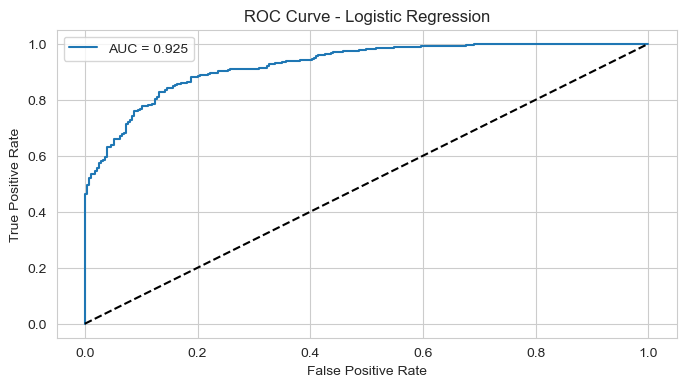

ROC AUC = 0.925


In [20]:
logit_preds = []

for c in ['area','bedrooms','bathrooms','stories','parking']:
    if c in df.columns:
        logit_preds.append(c)
for b in binary_cols:
    if b in df.columns:
        logit_preds.append(b)
if 'furnishingstatus' in df.columns:
    logit_preds.append('C(furnishingstatus)')

formula_logit = "HighPrice ~ " + " + ".join(logit_preds)
print("Logistic Regression Formula:")
print(formula_logit)

model_cols = ['HighPrice'] + [c for c in ['area','bedrooms','bathrooms','stories','parking'] + binary_cols]
if 'furnishingstatus' in df.columns:
    model_cols.append('furnishingstatus')
df_logit = df[model_cols].dropna()

logit = smf.logit(formula=formula_logit, data=df_logit).fit(disp=False)
print(logit.summary())

# Odds ratios + confidence intervals
params = logit.params
conf = logit.conf_int()

odds = np.exp(params)
conf_odds = np.exp(conf)

or_table = pd.DataFrame({
    'coef': params,
    'odds_ratio': odds,
    'ci_lower': conf_odds[0],
    'ci_upper': conf_odds[1],
    'pvalue': logit.pvalues
})
print("\nOdds Ratios:")
display(or_table.round(4))

# ROC/AUC curve
try:
    from sklearn.metrics import roc_auc_score, roc_curve
    preds = logit.predict(df_logit)
    auc = roc_auc_score(df_logit['HighPrice'], preds)
    fpr, tpr, _ = roc_curve(df_logit['HighPrice'], preds)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Logistic Regression")
    plt.legend()
    plt.show()

    print(f"ROC AUC = {auc:.3f}")
except Exception as e:
    print("ROC/AUC not calculated (sklearn may not be installed):", e)